In [1]:
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import tensor
from bpemb import BPEmb
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

#import dask.dataframe as dd
#from dask.multiprocessing import get

In [2]:
bpemb_en = BPEmb(lang="en", dim=300)

In [3]:
issues_df = pd.read_pickle('issues_df.pkl', 'gzip')
dataset_df = pd.read_pickle('dataset_df.pkl', 'gzip')

In [4]:
dataset_df = dataset_df[dataset_df['tokenized'].map(lambda d: len(d)) > 0]

In [ ]:
dataset_df = dataset_df.drop(columns=['filename', 'file_content'])
issues_df = issues_df.drop(columns=['text'])

In [ ]:
issues_df = pd.read_csv('./filtered_data/issues_data_etlegacy.csv')
dataset_df = pd.read_csv('./filtered_data/file_data_etlegacy.csv')

In [ ]:
dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)
issues_df = issues_df.set_index('id')

In [ ]:
dataset_df.head()

In [ ]:
issues_df.head()

In [ ]:
dataset_df['file_content'] = dataset_df['file_content'].fillna('')
issues_df['title'] = issues_df['title'].fillna('')
issues_df['body'] = issues_df['body'].fillna('')

In [ ]:
issues_df['text'] = issues_df['title'] + ' ' + issues_df['body']
issues_df = issues_df[['text']]

In [ ]:
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return bpemb_en.encode_ids(text)

In [ ]:
issues_df['tokenized'] = issues_df.apply(lambda row: tokenize(row['text']), axis=1)
ddata = dd.from_pandas(dataset_df, npartitions=30)
dataset_df['tokenized'] = ddata.map_partitions(lambda df: df.apply(lambda row: tokenize(row['file_content']), axis=1)).compute(scheduler='processes')  

In [ ]:
vocab = set()
issues_df.apply(lambda x: vocab.update(str(x['title']).split()), axis=1)
issues_df.apply(lambda x: vocab.update(str(x['body']).split()), axis=1)
dataset_df.apply(lambda x: vocab.update(str(x['file_content']).split()), axis=1)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [5]:
class SourceCodeDataset(Dataset):
    def __init__(self, sourceCode, issues):
        self.source_code = sourceCode
        self.issues = issues
    
    def __len__(self):
        return len(self.source_code)
    
    def __getitem__(self, idx):
        y = 1 if self.source_code.iloc[idx]['related'] == True else 0
        y = tensor(y).float()
        # Return shape : (code, issue, is_related)
        return (tensor(self.source_code.iloc[idx]['tokenized']),
                tensor(self.issues.loc[self.source_code.iloc[idx]['issue']]['tokenized'])), y

In [6]:
dataset = SourceCodeDataset(dataset_df, issues_df)
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [7]:
batch_size = 16
# vocab_size = len(words)

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    (x1, x2) = zip(*xx)
    
    x1_lens = [len(x) for x in x1]
    x2_lens = [len(x) for x in x2]
    
    x1_pad = pad_sequence(x1, batch_first=True, padding_value=0)
    x2_pad = pad_sequence(x2, batch_first=True, padding_value=0)
    
    return x1_pad, x2_pad, tensor(yy), x1_lens, x2_lens, len(yy)

train_dl = DataLoader(train_dataset, batch_size=batch_size, 
                      shuffle=True, collate_fn=pad_collate)

val_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class IssueLanguageModel(nn.Module):
    def __init__(self, embedding_dim=300):
        super(IssueLanguageModel, self).__init__()        
        
        self.embeddings = nn.Embedding.from_pretrained(tensor(bpemb_en.vectors))
        
        self.gru1 = nn.GRU(embedding_dim, 128, batch_first=True)
        self.gru2 = nn.GRU(embedding_dim, 256, batch_first=True)
        
        self.linear = nn.Linear(384, 128)
        self.linear2 = nn.Linear(128, 1)
        
        # Unfreeze embedding layer
        # self.embeddings.weight.requires_grad=True
    def forward(self, issue, source_code, issue_len, code_len):
        issue_em = self.embeddings(issue)
        code_em = self.embeddings(source_code)
        
        issue_packed = pack_padded_sequence(issue_em, issue_len, batch_first=True, enforce_sorted=False)
        code_packed = pack_padded_sequence(code_em, code_len, batch_first=True, enforce_sorted=False)
        
        output1, hidden1 = self.gru1(issue_packed)
        output2, hidden2 = self.gru2(code_packed)
        
        
        hidden = torch.cat((hidden1, hidden2), dim=2)
        
        out = self.linear(hidden[-1])
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [9]:
model = IssueLanguageModel().to(device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=tensor(2))
optimizer = optim.Adam(model.parameters(), 0.001)

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

643073

In [11]:
def train(epoch, name="train"):
    losses = []
    valid_losses = []
    valid_accuracy = []
    for e in tqdm(range(epoch)):
        model.train()
        total_loss = 0
        index = 0
        for code, issue, labels, code_len, issue_len, y_len in tqdm(train_dl):
            index += 1
            code = code.long().to(device)
            issue = issue.long().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            log_probs = model(issue, code, issue_len, code_len)
            
            loss = loss_function(log_probs.view(-1), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if index%50 == 0:
                print("Loss at {}: {}".format(index, loss.item()))
        losses.append(total_loss)
        print("Loss: {}".format(sum(losses)/len(losses)))
        valid_loss, valid_ac = validation_metrics()
        print("Valid Loss: {}, Valid Accuracy:{}".format(valid_loss, valid_ac))
        valid_losses.append(valid_loss)
        valid_accuracy.append(valid_ac)
        torch.save(model, './code_issue_{}_{}.pt'.format(name, e))
    return losses, valid_losses, valid_accuracy

In [12]:
def validation_metrics():
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for code, issue, labels, code_len, issue_len, y_len in tqdm(val_dl):
            code = code.long().to(device)
            issue = issue.long().to(device)
            labels = labels.to(device)
            log_probs = model(issue, code, issue_len, code_len).view(-1)
            loss = loss_function(log_probs, labels)
            pred = (torch.sigmoid(log_probs) >= 0.5).float()
            correct += (pred==labels).sum()
            total += labels.shape[0]
            sum_loss += loss.item()*labels.shape[0]
    return sum_loss/total, (correct.cpu().item()/total)

In [13]:
losses, valid_losses, valid_accuracy = train(5)

Loss at 50: 0.8453623652458191
Loss at 100: 0.9618614315986633
Loss at 150: 0.8790174722671509
Loss at 200: 0.6038080453872681
Loss at 250: 0.9448164105415344
Loss at 300: 0.839013934135437
Loss at 350: 0.9354188442230225
Loss at 400: 1.0240594148635864
Loss at 450: 0.7676931023597717
Loss at 500: 0.7517948150634766
Loss at 550: 0.6565334796905518
Loss at 600: 0.7541458010673523
Loss at 650: 0.42978435754776
Loss at 700: 0.5366275310516357
Loss at 750: 0.7590745091438293
Loss at 800: 0.7042762637138367
Loss at 850: 0.4571748375892639
Loss at 900: 0.6003894805908203
Loss at 950: 0.6785720586776733
Loss at 1000: 0.5041079521179199
Loss at 1050: 0.6442482471466064
Loss at 1100: 0.5452622771263123
Loss at 1150: 1.2552740573883057
Loss at 1200: 0.6634366512298584
Loss at 1250: 0.48202094435691833
Loss at 1300: 0.4208071231842041
Loss at 1350: 0.6280369162559509
Loss at 1400: 0.7427365779876709

Loss: 1025.3432393968105



Valid Loss: 0.6060686986863517, Valid Accuracy:0.7640449438202247


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:389: UserWarning: Couldn't retrieve source code for container of type IssueLanguageModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss at 50: 0.6064091324806213
Loss at 100: 0.752376914024353
Loss at 150: 0.3790472745895386
Loss at 200: 0.785139799118042
Loss at 250: 0.5825915336608887
Loss at 300: 0.4846237599849701
Loss at 350: 0.20988690853118896
Loss at 400: 0.5555323362350464
Loss at 450: 0.40942394733428955
Loss at 500: 0.6580698490142822
Loss at 550: 0.43937140703201294
Loss at 600: 0.800193190574646
Loss at 650: 0.37137919664382935
Loss at 700: 0.29824453592300415
Loss at 750: 0.759925365447998
Loss at 800: 0.3133503794670105
Loss at 850: 0.40366148948669434
Loss at 900: 0.351091206073761
Loss at 950: 0.4986228942871094
Loss at 1000: 0.736967146396637
Loss at 1050: 0.6203164458274841
Loss at 1100: 0.23212268948554993
Loss at 1150: 0.7792707681655884
Loss at 1200: 0.7746741771697998
Loss at 1250: 0.43547242879867554
Loss at 1300: 0.5295106172561646
Loss at 1350: 0.32307931780815125
Loss at 1400: 0.48203229904174805

Loss: 880.867774348706



Valid Loss: 0.5418007155674036, Valid Accuracy:0.8053772070626003


Loss at 50: 0.4858609437942505
Loss at 100: 0.44013845920562744
Loss at 150: 0.3520893454551697
Loss at 200: 0.1874331682920456
Loss at 250: 0.41153523325920105
Loss at 300: 0.49911022186279297
Loss at 350: 0.32714495062828064
Loss at 400: 0.37936103343963623
Loss at 450: 0.4967108368873596
Loss at 500: 0.39003607630729675
Loss at 550: 0.676710844039917
Loss at 600: 0.5092476010322571
Loss at 650: 0.44347119331359863
Loss at 700: 0.5678231716156006
Loss at 750: 0.3858027458190918
Loss at 800: 0.8413717746734619
Loss at 850: 0.5623383522033691
Loss at 900: 0.4844435751438141
Loss at 950: 0.4397645890712738
Loss at 1000: 0.8257051110267639
Loss at 1050: 0.5044587850570679
Loss at 1100: 0.2598825693130493
Loss at 1150: 0.5299638509750366
Loss at 1200: 1.1267611980438232
Loss at 1250: 0.8594214916229248
Loss at 1300: 0.573067307472229
Loss at 1350: 0.2779991626739502
Loss at 1400: 0.2210543155670166

Loss: 798.1673285253346



Valid Loss: 0.4661803657419226, Valid Accuracy:0.8515248796147673


Loss at 50: 0.24710121750831604
Loss at 100: 0.4254598617553711
Loss at 150: 0.359033465385437
Loss at 200: 0.39391136169433594
Loss at 250: 0.2679060697555542
Loss at 300: 0.22942426800727844
Loss at 350: 0.8171278238296509
Loss at 400: 0.3140401840209961
Loss at 450: 0.2200726717710495
Loss at 500: 0.5608479380607605
Loss at 550: 0.20027896761894226
Loss at 600: 0.17983096837997437
Loss at 650: 0.337430477142334
Loss at 700: 0.2983178496360779
Loss at 750: 0.3387349843978882
Loss at 800: 0.240153506398201
Loss at 850: 0.42006126046180725
Loss at 900: 1.1347547769546509
Loss at 950: 0.17673033475875854
Loss at 1000: 0.672601580619812
Loss at 1050: 0.5993540287017822
Loss at 1100: 0.454742431640625
Loss at 1150: 0.767629861831665
Loss at 1200: 0.4059235155582428
Loss at 1250: 0.3684041202068329
Loss at 1300: 0.45467835664749146
Loss at 1350: 0.12694595754146576
Loss at 1400: 0.4104342460632324

Loss: 741.0322014195845



Valid Loss: 0.46131880650742285, Valid Accuracy:0.8282504012841091


Loss at 50: 0.21264910697937012
Loss at 100: 0.08166082203388214
Loss at 150: 0.09334981441497803
Loss at 200: 0.35828137397766113
Loss at 250: 0.27606844902038574
Loss at 300: 0.3852655589580536
Loss at 350: 0.29569312930107117
Loss at 400: 0.4032301604747772
Loss at 450: 0.40227290987968445
Loss at 500: 0.11137624084949493
Loss at 550: 0.2158871442079544
Loss at 600: 0.16507700085639954
Loss at 650: 0.48838549852371216
Loss at 700: 0.292464941740036
Loss at 750: 0.3734383285045624
Loss at 800: 0.3788444697856903
Loss at 850: 1.3085095882415771
Loss at 900: 0.4768800735473633
Loss at 950: 0.5446983575820923
Loss at 1000: 0.28542497754096985
Loss at 1050: 0.32707679271698
Loss at 1100: 0.2251860499382019
Loss at 1150: 0.2845047116279602
Loss at 1200: 0.2729198932647705
Loss at 1250: 0.3174692690372467
Loss at 1300: 0.661622166633606
Loss at 1350: 0.17520520091056824
Loss at 1400: 0.3173750936985016

Loss: 699.0739251002669



Valid Loss: 0.42810371482257475, Valid Accuracy:0.8651685393258427



In [ ]:
losses

In [ ]:
validation_metrics()

In [21]:

l

[1025.3432393968105,
 736.3923093006015,
 632.7664368785918,
 569.626820102334,
 531.2408198229969]

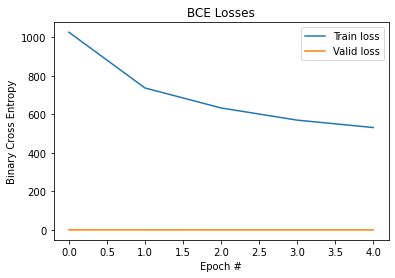

In [19]:
f = plt.figure()
plt.plot(losses)
plt.plot(valid_losses)
plt.title('BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Train loss', 'Valid loss'], loc='upper right')
plt.show()
f.savefig("losses.pdf", bbox_inches='tight')

In [ ]:
predict = model("delete test")

In [ ]:
torch.argmax(predict)

In [ ]:
issues_df.to_pickle('issues_df.pkl', 'gzip', 4)

In [ ]:
dataset_df.to_pickle('dataset_df.pkl', 'gzip', 4)

In [ ]:
torch.save(model, './code_issue_2.pt')

In [ ]:
issues_df_polybar = pd.read_csv('./issues_data_polybar.csv')
dataset_df_polybar = pd.read_csv('./file_data_polybar.csv')
dataset_df_polybar = dataset_df_polybar.sample(frac=1).reset_index(drop=True)
issues_df_polybar = issues_df_polybar.set_index('id')

dataset_df_polybar['file_content'] = dataset_df_polybar['file_content'].fillna('')
issues_df_polybar['title'] = issues_df_polybar['title'].fillna('')
issues_df_polybar['body'] = issues_df_polybar['body'].fillna('')

issues_df_polybar['text'] = issues_df_polybar['title'] + ' ' + issues_df_polybar['body']
issues_df_polybar = issues_df_polybar[['text']]

In [ ]:
issues_df_polybar['tokenized'] = issues_df_polybar.apply(lambda row: tokenize(row['text']), axis=1)

dataset_df_polybar['tokenized'] = dataset_df_polybar.apply(lambda row: tokenize(row['file_content']), axis=1)

In [ ]:
dataset_df_polybar = dataset_df_polybar[dataset_df_polybar['tokenized'].map(lambda d: len(d)) > 0]

In [ ]:
dataset = SourceCodeDataset(dataset_df_polybar, issues_df_polybar)
val_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [ ]:
dataset_df_polybar.head()

In [ ]:
l_i = tensor(len(issues_df_polybar.loc[428]['tokenized'])).view(1)
l_c = tensor(len(dataset_df_polybar.iloc[1]['tokenized'])).view(1)

model(tensor(issues_df_polybar.loc[428]['tokenized']).to(device).view(1,-1), 
      tensor(dataset_df_polybar.iloc[1]['tokenized']).to(device).view(1,-1), 
      l_i, l_c)

In [ ]:
model.embeddings.weight.requires_grad=True
sum(p.numel() for p in model.parameters() if p.requires_grad)

3643073

In [ ]:
optimizer = optim.Adam(model.parameters(), 0.0001)

In [ ]:
losses_2, valid_losses_2, valid_accuracy_2 = train(5, 'fine_tune')

Loss at 50: 0.40357568860054016
Loss at 100: 0.24430696666240692
Loss at 150: 0.298896849155426
Loss at 200: 0.2609492540359497
Loss at 250: 0.22094503045082092
Loss at 300: 0.44137042760849
Loss at 350: 0.3011220395565033
Loss at 400: 0.22029244899749756
Loss at 450: 0.20124082267284393
Loss at 500: 0.491374671459198
Loss at 550: 0.18230867385864258
Loss at 600: 0.466395765542984
Loss at 650: 0.494792103767395
Loss at 700: 0.3463408946990967
Loss at 750: 0.45219022035598755
Loss at 800: 0.07997545599937439
Loss at 850: 0.451829731464386
Loss at 900: 0.4042198657989502
Loss at 950: 0.3849692940711975
Loss at 1000: 0.20256683230400085
Loss at 1050: 0.21432535350322723
Loss at 1100: 0.24244531989097595
Loss at 1150: 0.25592947006225586
Loss at 1200: 0.4457409679889679
Loss at 1250: 0.25089097023010254
Loss at 1300: 0.28767484426498413
Loss at 1350: 0.4108814597129822
Loss at 1400: 0.13429102301597595

Loss: 417.4664582395926



Valid Loss: 0.375017884431069, Valid Accuracy:0.8804173354735152


Loss at 50: 0.7045669555664062
Loss at 100: 0.38264891505241394
Loss at 150: 0.49698787927627563
Loss at 200: 0.2894057631492615
Loss at 250: 0.12141633033752441
Loss at 300: 0.23784545063972473
Loss at 350: 0.5282330513000488
Loss at 400: 0.1720716655254364
Loss at 450: 0.4500822126865387
Loss at 500: 0.23575665056705475
Loss at 550: 0.09641720354557037
Loss at 600: 0.2533559799194336
Loss at 650: 0.25516384840011597
Loss at 700: 0.09807219356298447
Loss at 750: 0.4555593430995941
Loss at 800: 0.11878301203250885
Loss at 850: 0.2703417241573334
Loss at 900: 0.0946386456489563
Loss at 950: 0.20187467336654663
Loss at 1000: 0.3358008563518524
Loss at 1050: 0.09854453802108765
Loss at 1100: 0.24747049808502197
Loss at 1150: 0.14468644559383392
Loss at 1200: 0.19160640239715576
Loss at 1250: 0.033220380544662476
Loss at 1300: 0.3838377594947815
Loss at 1350: 0.41382408142089844
Loss at 1400: 0.10994065552949905

Loss: 395.9868992189877



Valid Loss: 0.36198499829868636, Valid Accuracy:0.8840288924558587


Loss at 50: 0.0876285657286644
Loss at 100: 0.11349643766880035
Loss at 150: 0.17666572332382202
Loss at 200: 0.3392982482910156
Loss at 250: 0.05987505614757538
Loss at 300: 0.18539172410964966
Loss at 350: 0.16666445136070251
Loss at 400: 0.3043198585510254
Loss at 450: 0.5087729692459106
Loss at 500: 0.08683447539806366
Loss at 550: 0.36446595191955566
Loss at 600: 0.15578123927116394
Loss at 650: 0.16281020641326904
Loss at 700: 0.3056735694408417
Loss at 750: 0.38953864574432373
Loss at 800: 0.06486149877309799
Loss at 850: 0.1830611675977707
Loss at 900: 0.24945056438446045
Loss at 950: 0.3105435371398926
Loss at 1000: 0.5606760382652283
Loss at 1050: 0.18454119563102722
Loss at 1100: 0.29334577918052673
Loss at 1150: 0.24532368779182434
Loss at 1200: 0.37208738923072815
Loss at 1250: 0.18258419632911682
Loss at 1300: 0.18435251712799072
Loss at 1350: 0.3471859097480774
Loss at 1400: 0.271540105342865

Loss: 378.9497022757617



Valid Loss: 0.35591706657486205, Valid Accuracy:0.8808186195826645


Loss at 50: 0.24885794520378113
Loss at 100: 0.24189206957817078
Loss at 150: 0.16208066046237946




KeyboardInterrupt: 

In [18]:
torch.save({'state_dict': model.state_dict()}, 'model-final.pth.tar')